In [1]:
# pip install torch torchvision torchmetrics pytorch-lightning tqdm numpy matplotlib tensorboard tensorboardX

In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load dataset

def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35,1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
])

In [4]:
train_dataset = torchvision.datasets.DatasetFolder("processed/train/", loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

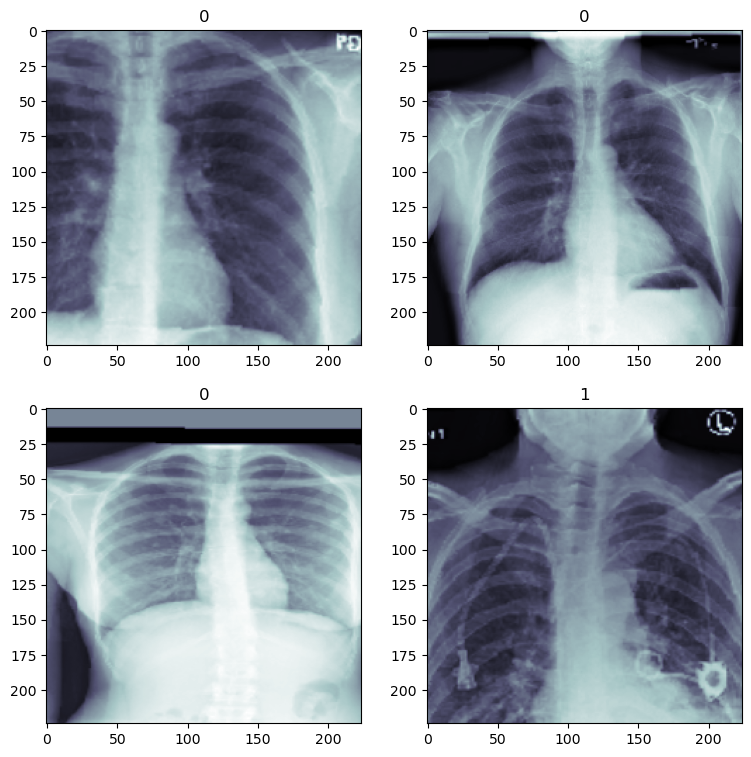

In [43]:
fig, axis = plt.subplots(2, 2, figsize=(9,9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(label)

In [6]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
np.unique(train_dataset.targets, return_counts=True) #there are aprox three times more cases without Phneumonia than cases with Phneumonia, this is an unbalaced dataset

(array([0, 1]), array([18593,  5407]))

In [8]:
torchvision.models.resnet18() #see the structure of the previously trained model i will adapt

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Train model

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        
    def forward(self, data):
        pred = self.model(data)
        return pred
        
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0] # forward
        loss = self.loss_fn(pred, label)
        
        self.log("Train Logs", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
        
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0] # forward
        loss = self.loss_fn(pred, label)
        
        self.log("Val Logs", loss)
        val_acc = self.val_acc(torch.sigmoid(pred), label.int())
        self.log("Val ACC", val_acc, prog_bar=True, on_epoch=True)
        return loss
        
    def on_val_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())

    def configure_optimizers(self):
        return [self.optimizer]

In [30]:
model = PneumoniaModel()

In [31]:
checkpoint_callback = ModelCheckpoint(
    monitor= "Val ACC",
    save_top_k = 10,
    mode = "max",)

In [32]:
trainer = pl.Trainer(
    accelerator="gpu",   
    devices=1, 
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=35
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ckpt_path = "./logs/lightning_logs/version_6/checkpoints/epoch=28-step=10875.ckpt"
model = PneumoniaModel.load_from_checkpoint(ckpt_path)
model.eval().to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [36]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [40]:
import pandas as pd
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix

acc_metric       = Accuracy(task="binary")
precision_metric = Precision(task="binary")
recall_metric    = Recall(task="binary")
cm_metric        = ConfusionMatrix(task="binary", num_classes=2)

acc       = acc_metric(preds, labels).item()
precision = precision_metric(preds, labels).item()
recall    = recall_metric(preds, labels).item()
cm        = cm_metric(preds, labels).numpy()  

df = pd.DataFrame({
    "Accuracy":       [acc],
    "Precision":      [precision],
    "Recall":         [recall],
    "Confusion Mat.": [cm.tolist()]   
})

df

,Accuracy,Precision,Recall,Confusion Mat.
0,0.805514,0.544768,0.834711,"[[1657, 422], [100, 505]]"
